### Save files

Use the rgb, classifications and landcover files to create data samples


Either iterate over the landcover, find rgb if scl is valid, create all of the available samples and split them into 80/10/10 train/val/test.

Or use 1 tile for test, one for validation and the rest for training, problem is that they can overlap a little and they don't all contain the same amounts of valid samples.


The tiles are 13 but some are images of the same area photographed at different dates. So there are really only 9 different tiles.

In [1]:
import rasterio as rio
from rasterio import warp
import numpy as np
import matplotlib.pyplot as plt

from rasterio.windows import Window
from rasterio.transform import Affine

from shapely.geometry import box

In [2]:
import os
import matplotlib.patches as mpatches
import ast
from tqdm import tqdm
import gc

In [3]:
rgb_path = "satellite/rgb/"
scl_path = "satellite/classifications/"
rgb_files = os.listdir(rgb_path)
scl_files = os.listdir(scl_path)

In [4]:
rgb_files

['T32UMF_20170619T103021_TCI_10m.jp2',
 'T32UMG_20170829T105019_TCI_10m.jp2',
 'T32UNG_20170823T103019_TCI_10m.jp2',
 'T32UPF_20170619T103021_TCI_10m.jp2',
 'T32UPF_20170709T103021_TCI_10m.jp2',
 'T32UPF_20170823T103019_TCI_10m.jp2',
 'T32UPG_20170527T102031_TCI_10m.jp2',
 'T32UPG_20170823T103019_TCI_10m.jp2',
 'T32VNH_20170823T103019_TCI_10m.jp2',
 'T32VNJ_20170823T103019_TCI_10m.jp2',
 'T32VPH_20170823T103019_TCI_10m.jp2',
 'T33UUB_20170527T102031_TCI_10m.jp2',
 'T33UUB_20170619T103021_TCI_10m.jp2']

In [5]:
[a[7:7+8] for a in rgb_files]

['20170619',
 '20170829',
 '20170823',
 '20170619',
 '20170709',
 '20170823',
 '20170527',
 '20170823',
 '20170823',
 '20170823',
 '20170823',
 '20170527',
 '20170619']

In [6]:
scl_files

['T32UMF_20170619T103021_SCL_20m.jp2',
 'T32UMG_20170829T105019_SCL_20m.jp2',
 'T32UNG_20170823T103019_SCL_20m.jp2',
 'T32UPF_20170619T103021_SCL_20m.jp2',
 'T32UPF_20170709T103021_SCL_20m.jp2',
 'T32UPF_20170823T103019_SCL_20m.jp2',
 'T32UPG_20170527T102031_SCL_20m.jp2',
 'T32UPG_20170823T103019_SCL_20m.jp2',
 'T32VNH_20170823T103019_SCL_20m.jp2',
 'T32VNJ_20170823T103019_SCL_20m.jp2',
 'T32VPH_20170823T103019_SCL_20m.jp2',
 'T33UUB_20170527T102031_SCL_20m.jp2',
 'T33UUB_20170619T103021_SCL_20m.jp2']

In [7]:
tiles = []
for f in rgb_files:
    tile = f[3:6]
    if tile not in tiles:
        tiles.append(tile)

In [8]:
# Rest is train tiles
val_tile = "UNG"
test_tile = "UPG"

In [9]:
tiles

['UMF', 'UMG', 'UNG', 'UPF', 'UPG', 'VNH', 'VNJ', 'VPH', 'UUB']

In [10]:
labels = ["No data", "Saturated or defective", "Dark area pixels", "Cloud shadows", "Vegetation", "Not vegetated", "Water", "Unclassified", "Cloud medium probability","Cloud high probability","Thin cirrus", "Snow"]
#labels = [f"{i} {labels[i]}" for i in range(len(labels))]

In [11]:
labels

['No data',
 'Saturated or defective',
 'Dark area pixels',
 'Cloud shadows',
 'Vegetation',
 'Not vegetated',
 'Water',
 'Unclassified',
 'Cloud medium probability',
 'Cloud high probability',
 'Thin cirrus',
 'Snow']

In [12]:
lc_labels = {
    str([255, 255, 255, 255]):"Clouds",
    str([210,0,0,255]):"Artificial surfaces and constructions",
    str([253,211,39,255]):"Cultivated areas",
    str([176,91,16,255]):"Vineyards",
    str([35,152,0,255]):"Broadleaf tree cover",
    str([8,98,0,255]):"Coniferous tree cover",
    str([249,150,39,255]):"Herbaceous vegetation",
    str([141,139,0,255]):"Moors and Heathland",
    str([95,53,6,255]):"Sclerophyllous vegetation",
    str([149,107,196,255]):"Marshes",
    str([77,37,106,255]):"Peatbogs",
    str([154,154,154,255]):"Natural material surfaces",
    str([106,255,255,255]):"Permanent snow covered surfaces",
    str([20,69,249,255]):"Water bodies",
    str([255,255,255,255]):"No data",
}

In [13]:
for i,l in enumerate(lc_labels):
    print(i, "&",lc_labels[l], "\\\\")

0 & No data \\
1 & Artificial surfaces and constructions \\
2 & Cultivated areas \\
3 & Vineyards \\
4 & Broadleaf tree cover \\
5 & Coniferous tree cover \\
6 & Herbaceous vegetation \\
7 & Moors and Heathland \\
8 & Sclerophyllous vegetation \\
9 & Marshes \\
10 & Peatbogs \\
11 & Natural material surfaces \\
12 & Permanent snow covered surfaces \\
13 & Water bodies \\


In [14]:
# align classfication data to rgb data because of different spatial resolution
def align(src, dst, src_arr, dst_arr):
    src_new = np.repeat(np.zeros_like(dst_arr[[0]]), src.count, 0)
    warp.reproject(
        src_arr, src_new, 
        src_crs=src.crs, dst_crs=dst.crs,
        src_transform=src.transform, dst_transform=dst.transform,
        dst_resolution=dst.res,
        resampling=warp.Resampling.nearest
    )
    return src_new

In [15]:
lc = rio.open("denmark_landcover.tif")

In [16]:
def get_scl_rgb_lc(idx):
    rgb = rio.open(rgb_path + rgb_files[idx])
    scl = rio.open(scl_path + scl_files[idx])
    
    rgb_r = rgb.read()
    scl_a = align(scl, rgb, scl.read(), rgb_r)
    lc_r = lc.read()
    lc_a = align(lc, rgb, lc_r, rgb_r)
    del lc_r
    scl.close()
    rgb.close()
    return scl_a, rgb_r, lc_a

In [17]:
labels

['No data',
 'Saturated or defective',
 'Dark area pixels',
 'Cloud shadows',
 'Vegetation',
 'Not vegetated',
 'Water',
 'Unclassified',
 'Cloud medium probability',
 'Cloud high probability',
 'Thin cirrus',
 'Snow']

In [18]:
water = 6
cloud = [3,8,9]
invalid = [0, 1, 2, 7, 10, 11]
def is_lc_valid(scl):
    classes = scl.flatten()
    n = scl.shape[0] * scl.shape[1]
    
    if n * .4 < classes[classes == water].size:
        # too much water
      #  print("too much water")
        return False
    # if more than 10% clouds or no data
    sum_invalid = classes[classes == water].size
    for c in cloud:
        sum_invalid += classes[classes == c].size
    
    for c in invalid:
        sum_invalid += classes[classes == c].size
        
    return sum_invalid < n * 0.1

In [19]:
def plot_lc_hist(lc_256):
    a = np.vstack(np.transpose(lc_256))
    d = {}
    for i in a:
        l = str(list(i))
        if l not in d:
            d[l] = 0
        d[l] += 1

    labs = []
    for l in d.keys():
        labs.append(lc_labels[l])

    plt.bar(labs, d.values())
    plt.xticks(rotation = "vertical")

In [20]:
def plot_scl_hist(scl_256):
    a = scl_256.flatten()
    d = {}
    for i in a:
        # l = str(list(i))
        l = i
        if l not in d:
            d[l] = 0
        d[l] += 1
    labs = []
    for l in d.keys():
        labs.append(labels[l])

    plt.bar(labs, d.values())
    plt.xticks(rotation = "vertical")

In [21]:
def print_all(scl_256, rgb_256, lc_256, root_dir):
    cmap = plt.get_cmap("viridis")
    fig, ax = plt.subplots(1,3, figsize=(12,16))
    fig.tight_layout()
    ax[0].imshow(np.moveaxis(lc_256, 0, -1))
    ax[0].set_title("Land cover")
    ax[1].imshow(np.moveaxis(rgb_256, 0, -1))
    ax[1].set_title("Satellite image")
    ax[2].imshow(scl_256/11 , cmap=cmap, vmin=0, vmax=1)
    ax[2].set_title("Scence classification")

    patches = [mpatches.Patch(color=np.array(ast.literal_eval(i))/255, label=lc_labels[i]) for i in lc_labels]
    l1 = plt.legend(handles=patches, loc="best",bbox_to_anchor=(-.8,-.3,1,.1), ncol=3, title="Land cover labels")

    patches2 = [mpatches.Patch(color=cmap(i/11), label=labels[i]) for i in range(len(labels))]
    l2 = plt.legend(handles=patches2, loc="best",bbox_to_anchor=(0,1.5,1,.1), ncol=3, title="Scene classification labels")
    plt.gca().add_artist(l1)

    fn = rgb_files[idx].split("_")
    fn = f"{root_dir}/all/{fn[0][3:6]}_{w}_{h}.png"
    
    plt.savefig(fn)
    plt.close()

In [22]:
def save_imgs(scl_256, rgb_256, lc_256, root_dir):
    if not is_lc_valid(scl_256):
        return False
    fn = rgb_files[idx].split("_")
    fn = fn[0][3:6] #f"{fn[0]}_{fn[1]}"
    pathname = f"{fn}_{w}_{h}.png"
    scl_fn = f"{root_dir}/scl/{pathname}"
    lc_fn = f"{root_dir}/lc/{pathname}"
    rgb_fn = f"{root_dir}/rgb/{pathname}"

    plt.imsave(scl_fn, scl_256)
    lc_256 = np.ascontiguousarray(np.moveaxis(lc_256, 0, -1))
    rgb_256 = np.ascontiguousarray(np.moveaxis(rgb_256, 0, -1))

    plt.imsave(lc_fn, lc_256)
    plt.imsave(rgb_fn, rgb_256)
    plt.close()
    return True

In [23]:
# create dirs
grid_dir = "grid_dir"
if not os.path.exists(grid_dir):
    os.mkdir(grid_dir)
possible_dirs = [f"{grid_dir}/train", f"{grid_dir}/test", f"{grid_dir}/val"]
possible_subdirs = ["rgb", "all", "lc","scl"]
for d in possible_dirs:
    if not os.path.exists(d):
        os.mkdir(d)
    for sd in possible_subdirs:
        full_sd = f"{d}/{sd}"
        if not os.path.exists(full_sd):
            os.mkdir(full_sd)

0 / 12, grid_dir2/train:  90%|███████████████████████████████████████████████████▌     | 76/84 [06:45<00:42,  5.34s/it]


KeyboardInterrupt: 

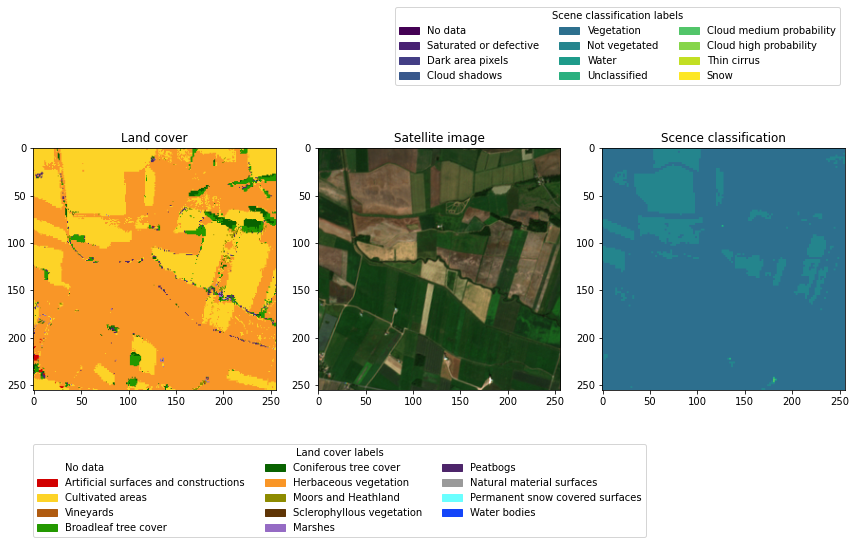

In [24]:
# save them not randomly

for idx in range(0,len(rgb_files)):
    j=0
    # save 1000 samples
    tile_name = rgb_files[idx].split("_")[0][3:6]
    
    window_slide_size = 128
    if tile_name == test_tile:
        root_dir = f"{grid_dir}/test"
        window_slide_size = 256
    elif tile_name == val_tile:
        root_dir = f"{grid_dir}/val"
        window_slide_size = 256
    else:
        root_dir = f"{grid_dir}/train"
    
    
    scl_a, rgb_r, lc_a = get_scl_rgb_lc(idx)
    loop = tqdm(range(0, rgb_r.shape[2] - 256, window_slide_size))
    loop.set_description(f"{idx} / {len(rgb_files)-1}, {root_dir}")
    for w in loop:
        for h in range(0, rgb_r.shape[1] - 256, 128):

            lc_256 = lc_a[:,h:h+256,w:w+256]
            rgb_256 = rgb_r[:,h:h+256,w:w+256]
            scl_256 = scl_a[0][h:h+256,w:w+256]

            if save_imgs(scl_256, rgb_256, lc_256, root_dir):
                print_all(scl_256, rgb_256, lc_256, root_dir)
                
    
                